## Beautiful Demo

Loads training data and shows an example training face

reading csv: 3.667959451675415
formatting to numpy matrices: 2.216933250427246
picking random data: 0.007237911224365234
Formatting data: 3.933906555175781e-05


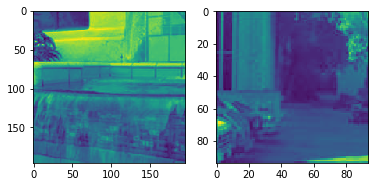

In [1]:
from matplotlib import pyplot as plt
from read_data import training_validation

from time import time
from random import choice

(training_images, training_labels), (test_images, test_labels) = training_validation()

sample_image_positive = choice(training_images)
sample_image_negative = choice(test_images)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(sample_image_positive)
ax2.imshow(sample_image_negative)
plt.show()



## Example of feature selection used

-539627.0
-171321.0
299067.0
-248081.0
-329763.0


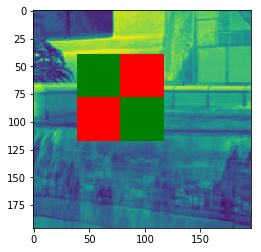

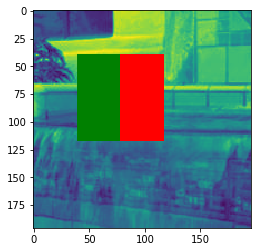

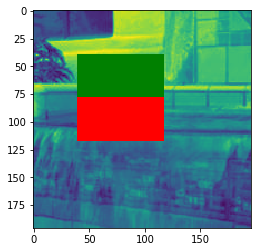

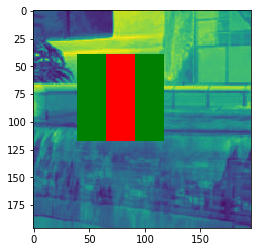

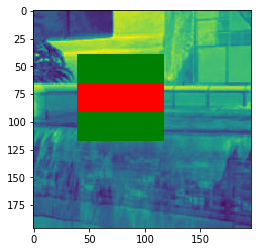

In [2]:
from features import *
from processing import IntegralImage

fsize = FeatureSize(0.2, 0.2, 0.4, 0.4)
ii = IntegralImage(sample_image_positive)
ii.process()

f = Feature(fsize, A)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, B2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C1)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))

f = Feature(fsize, C2)
fig, ax1 = plt.subplots(1, 1)
f.print_feature(ii, ax1)
print(f.calculate(ii))


plt.show()

## Example of Feature Generation

In [ ]:
from features import *
count = 0
for sz in generate_all_sizes():
    count += 1
print(count)

## Format training and test data

The format is adapted for the special ada boosted version, to extract features, therefore to train the normal bayes
we have to transpose the data to get image x features instead of features x images.

In [3]:
import processing
import features
import os
import pickle
from numpy import save, load




outTrain = None
outTest = None

training = None
test = None
IItraining = None
IItest = None
if not os.path.isfile("training_feature_matrix.npy"):
    all_features = features.generate_all_features()
    
    print("Stage 1")
    IItraining = processing.bulk_II(training_images)
    IItest = processing.bulk_II(test_images)
    
    outTrain = open('IITraining.pkl', 'wb')
    outTest = open('IITesting.pkl', 'wb')
    pickle.dump(IItraining, outTrain)
    pickle.dump(IItest, outTest)
    outTrain.close()
    outTest.close()
    
    print("Stage 2")
    training = features.get_feature_matrix(IItraining, all_features)
    test = features.get_feature_matrix(IItest, all_features)

    """ _ is same as above. """

    save("training_feature_matrix", training)
    save("test_feature_matrix", test)
    

    training_for_bayes = training.T
    test_for_bayes = test.T
else:
    training = load("training_feature_matrix.npy")
    test = load("test_feature_matrix.npy")
    outTrain = open('IITraining.pkl', 'rb')
    outTest = open('IITesting.pkl', 'rb')
    IItraining = pickle.load(outTrain)
    IItest = pickle.load(outTest)
    outTrain.close()
    outTest.close()
    



## Testing Naive Bayes 

Naive bayes based on Normal distribution

In [ ]:
from naive_bayes import naive_bayes
from numpy import array, save
from sys import stdout
"""

classifier = naive_bayes()
training_labels = array(training_labels)
print(training_labels)

classifier.train(training_for_bayes, training_labels)
correct = 0
total = len(test_for_bayes)
print(total)

false_positive = None
false_negative = None

false_positives = 0
false_negatives = 0 
for index, image in enumerate(test_for_bayes):
    stdout.write("\r\r\r" + str(index) + str("\r\r\r"))
    
    prediction = classifier.predict(image)
    label = test_labels[index]
    
    false_positives += (prediction == 1 and label == 0)
    false_negatives += (prediction == 0 and label == 1)
    
    if prediction == 1 and label == 0:
        false_positive = test_images[index]
    
    if prediction == 0 and label == 0:
        false_negative = test_images[index]
        
    correct += 1 if classifier.predict(image) != test_labels[index] else 0
    

In [ ]:
print(correct)

In [ ]:
print(correct / total)

In [4]:
from cascade import cascade
from numpy import array

c = cascade(0.35, 0.7)
c.train(IItraining, array(training_labels), 0.05)

Starting training
Round we go!! Currently: 1.0  Target is:  0.05
Generate all features: 0.056571245193481445
get feature matrix: 34.60535216331482
Generating classifiers with 1 features
Feature matrix shape (19845, 189)
Training boosted classifier with 1 features
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1        

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb class


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb class

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a nb classifier

Calculating Maximum likelyhood for class 1                          
Training done.
Training a

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin



Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb cla

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin



Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb cla

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb class

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin



Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb cla


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb class


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin



Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb cla


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb class

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb class


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin



Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb cla

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb clas

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Trainin



Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb cla

Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.
Training a nb classifier


Training done.


KeyboardInterrupt: 